# Explanation pipeline

In [1]:
# Reload modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

# Import from code root directory
import sys; sys.path.insert(0, '../')

# Imports
from collections import OrderedDict
from access.amazon_doc2vec_reader import AmazonDoctovecReader
from access.amore_doc2vec_reader import AmoreDoctovecReader
from access.amore_bert_reader import AmoreBertReader
from access.amore_reader import AmoreReader
from access.amazon_pickle_reader import AmazonPickleReader
from detection.bounding_boxes import BoundingBoxes
from explanations.count_explainer import CountExplainer
from explanations.tfidf_explainer import TfidfExplainer
from explanations.wordcloud import Wordcloud
from explorer.search import Search

In [2]:
# Configuration
# Amazon text and embeddings directory (amazon_raw.pickle, amazon_bow_50.pickle, amazon_all.pickle)
data_directory_amazon = '/home/eml4u/EML4U/data/amazon-complete'
# AMORE benchmark directory
data_directory_amore = '/home/eml4u/EML4U/notebooks/amore/data/benchmark-ids/'
# AMORE benchmark ID
amore_benchmark_id = '1'

## Data Readers

Implementations of `ReaderInterface`. Creates instance `reader`. Provides:

- `get_distribution_ids():` Returns a list of available distribution IDs.
- `get_item_ids(distribution_id)`: Returns a list of item IDs for a given distribution ID.
- `get_text(item_id)`: Returns the text for the given dataset ID.
- `get_embeddings(item_id)`: Returns an embeddings vector for the given dataset ID.
- `get_dimensions()`: Returns the number of embeddings dimensions.

In [3]:
# Pickle reader (Amazon texts and Doc2Vec) for multiple usage
amazon_pickle_reader = AmazonPickleReader(data_directory_amazon)

In [4]:
# Amazon test 1
# 10,000 1-star items from 2007
# 10,000 5-star items from 2007
if False:
    reader = AmazonDoctovecReader()
    options = {}
    options['data_directory']     = data_directory_amazon
    options['distributions_file'] = '/tmp/amore_test_1.pickle'
    reader.initialize(options)
    reader.get_dimensions() # Method also reads all data

In [5]:
# Amazon test 2
# 2011: 25K positive and 25K negative
# 2012: 40K positive and 10K negative
if False:
    reader = AmazonDoctovecReader()
    options = {}
    options['data_directory']     = data_directory_amazon
    options['distributions_file'] = '/tmp/amore_test_2.pickle'
    reader.initialize(options)
    reader.get_dimensions() # Method also reads all data

In [ ]:
# AMORE Benchmark doc2vec reader
if True:
    reader = AmoreDoctovecReader()
    options = {}
    options['data_directory']     = data_directory_amazon
    options['amore_directory']    = data_directory_amore
    options['amore_benchmark_id'] = amore_benchmark_id
    reader.initialize(options)
    reader.get_dimensions() # Method also reads all data

AMORE directory:                    /home/eml4u/EML4U/notebooks/amore/data/benchmark-ids/
AMORE benchmark ID:                 1
AmoreDoctovecReader data directory: /home/eml4u/EML4U/data/amazon-complete
Loading embeddngs
AmazonPickleReader: Reading raw data
AmazonPickleReader: Reading bow50 data


In [48]:
# AMORE Benchmark BERT reader
if False:
    reader = AmoreBertReader()
    options = {}
    options['data_directory']       = data_directory_amazon
    options['amore_directory']      = data_directory_amore
    options['amore_benchmark_id']   = amore_benchmark_id
    options['amazon_pickle_reader'] = amazon_pickle_reader
    reader.initialize(options)
    reader.get_dimensions() # Method also reads all data

AMORE directory:                    /home/eml4u/EML4U/notebooks/amore/data/benchmark-ids/
AMORE benchmark ID:                 1
AmoreDoctovecReader data directory: /home/eml4u/EML4U/data/amazon-complete
Loading embeddngs


## Distribution information

In [49]:
distribution_a_id = reader.get_distribution_ids()[0]
distribution_b_id = reader.get_distribution_ids()[1]

print('Distribution IDs:', distribution_a_id, distribution_b_id)
print('Size', str(distribution_a_id) + ':', len(reader.get_item_ids(distribution_a_id)))
print('Size', str(distribution_b_id) + ':', len(reader.get_item_ids(distribution_b_id)))
print('Dimensions:', reader.get_dimensions())

Distribution IDs: 0 1
Size 0: 10000
Size 1: 10000
Dimensions: 768


## Drift Detectors

Implementations of `DetectionInterface`. Provides:

- `set_reader()`: Sets a ReaderInterface implementation to access data.
- `select_item_ids(distribution_a_id, distribution_b_id)`: Detects and returns a list of dataset IDs of distribution B.

In [50]:
# Gets outliers based on boundaries derived from single dimension values.
detector = BoundingBoxes()
detector.initialize({
    'percentile':          0.995,
    'enclosed_dimensions': reader.get_dimensions()
})
detector.set_reader(reader)

BoundingBoxes percentile:                            0.995
BoundingBoxes minimum number of enclosed dimensions: 768


In [51]:
# Detect drift and save results in drift_results
drift_results = OrderedDict()
drift_results[distribution_b_id] = detector.select_item_ids(distribution_a_id, distribution_b_id)
print('Drift result numbers of items ' + str(distribution_a_id) + ':', len(drift_results[distribution_b_id]), '/', len(reader.get_item_ids(distribution_a_id)), end='')
print(' (' + str(round(100*len(drift_results[distribution_b_id])/len(reader.get_item_ids(distribution_a_id)), 2)), '%)')

# Only required to compare A to B and B to A
if False:
    drift_results[distribution_a_id] = detector.select_item_ids(distribution_b_id, distribution_a_id)
    print('Drift result numbers of items ' + str(distribution_b_id) + ':', len(drift_results[distribution_a_id]), '/', len(reader.get_item_ids(distribution_b_id)), end='')
    print(' (' + str(round(100*len(drift_results[distribution_a_id])/len(reader.get_item_ids(distribution_b_id)), 2)), '%)')

BoundingBoxes: Collecting values of single dimensions
BoundingBoxes: Updating boundaries
BoundingBoxes: Filtering items
Drift result numbers of items 0: 816 / 10000 (8.16 %)


In [52]:
# Development: Loads perfect results
if False:
    amore_reader = AmoreReader(data_directory=data_directory_amore)
    drift_results[distribution_b_id] = amore_reader.get_drift_ids(amore_benchmark_id, subset=None)
    print('Size of perfect results:', len(drift_results[distribution_b_id]))
    print('Token base of perfect results:', amore_reader.get_drift_tokens(amore_benchmark_id, subset=None))

## Drift Explainers

In [53]:
base_ids = reader.get_item_ids(distribution_a_id) + reader.get_item_ids(distribution_b_id)# - 
base_ids = [x for x in base_ids if x not in drift_results[distribution_b_id]]
print('base_ids', len(base_ids))

base_ids 19184


In [54]:
if False:
    explainer = TfidfExplainer()
    explainer.initialize({'max_results':50})

In [55]:
if True:
    explainer = CountExplainer()
    explainer.initialize({'max_results':50})

CountExplainer max_results: 50


In [56]:
token_dict_a = explainer.get_token_dict(base_ids, drift_results[distribution_b_id], reader)
print(token_dict_a)

AmazonPickleReader: Reading raw data
{'troll': 0.001391127281500547, 'craven': 0.001142221619616302, 'samara': 0.000595117661900691, 'jong': 0.0005669053942890684, 'avp': 0.0005429518309366134, 'hellraiser': 0.000539119436598126, 'bewitched': 0.000538906281637786, 'ferrara': 0.0005186785351436483, 'gilliam': 0.0005066484647273358, 'runaways': 0.0004623605774005732, 'reid': 0.0004505436619446009, 'martians': 0.00042222481685280823, 'kazaf': 0.0004100881689563256, 'visser': 0.0004100881689563256, 'predator': 0.0004070018169790293, 'fulci': 0.00040625577461783825, 'rollerball': 0.00040210364783884063, 'pistols': 0.00039805809854001313, 'gothic': 0.00039422570420152587, 'carolyn': 0.0003940125492411856, 'marci': 0.0003779369295260456, 'kazaam': 0.0003779369295260456, 'tigger': 0.0003779369295260456, 'slater': 0.0003742111126677283, 'dukes': 0.00036196788729107567, 'ledger': 0.00035387678869342056, 'samatha': 0.000341740140796938, 'armitage': 0.000341740140796938, 'sndn': 0.0003417401407969

### Verification

In [57]:
amore_reader = AmoreReader(data_directory=data_directory_amore)

drift_ids = amore_reader.get_drift_ids(amore_benchmark_id, subset=None)
p = len(drift_ids)
print('p (drift IDs):', p)

n_ids = [i for i in reader.get_item_ids(distribution_b_id) if i not in drift_ids]
n = len(n_ids)
print('n', len(n_ids))

detected_ids = drift_results[distribution_b_id]
print('tp + fn (detected IDs):', len(detected_ids))

tp_ids = list(set(drift_ids).intersection(drift_results[distribution_b_id]))
tp = len(tp_ids)
print('tp', tp)

# fp = detected_ids - drift_ids
fp = [i for i in detected_ids if i not in drift_ids]
print('fp', len(fp))

tn_ids = [i for i in n_ids if i not in fp]
tn = len(tn_ids)
print('tn', tn)

# Accuracy (ACC) = (TP + TN)/(P + N)
accuracy = (tp + tn) / (p + n)
print('accuracy:', accuracy)

p (drift IDs): 1000
n 9000
tp + fn (detected IDs): 816
tp 47
fp 769
tn 8231
accuracy: 0.8278


In [58]:
drift_tokens = amore_reader.get_drift_tokens(amore_benchmark_id, subset=None)
print('drift_tokens', drift_tokens)
top_computed_tokens = list(token_dict_a.keys())[:len(drift_tokens)]
print('top_computed_tokens', top_computed_tokens)

drift_tokens ['excellent', 'best', 'great', 'love']
top_computed_tokens ['troll', 'craven', 'samara', 'jong']


### Visual representations

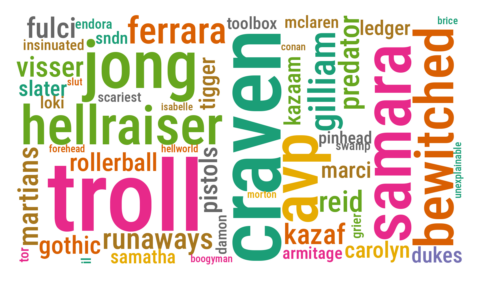

In [59]:
wordcloud = Wordcloud()
wordcloud.plot(wordcloud.get_wordcloud(token_dict_a))

In [60]:
if False:
    wordcloud = Wordcloud()
    wordcloud.plot(wordcloud.get_wordcloud(token_dict_b))

## Explorer

In [61]:
search = Search()
search.initialize({'reader':reader})

In [62]:
query = 'season'

In [63]:
#search_results_a = search.search(query, item_ids=drift_results[distribution_a_id], max=-1)

In [64]:
if False:
    search_results_b = search.search(query, item_ids=drift_results[distribution_b_id], max=-1)

In [65]:
# Print item IDs and texts
#search.print_results(search_results_a, max=10)

In [66]:
# Print item IDs and texts
#search.print_results(search_results_b, max=10)